In [1]:
from modelData import ModelData
from boltz.boltzmannEq import dYdx, computeCollisionTerms,computeDecayTerms
from scipy.integrate import solve_ivp,odeint
import numpy as np
from matplotlib import pyplot as plt
from tools.configParserWrapper import ConfigParserExt
import os
from tools.logger import setLogLevel

### Load input parameters

In [2]:
parfile = './input_parameters_CDFO.ini'
parser = ConfigParserExt(inline_comment_prefixes="#")   
ret = parser.read(parfile)
parser = parser.expandLoops()[0]
parserDict = parser.toDict(raw=False)

In [3]:
pars = parser['SolverParameters']
atol = pars['atol']
rtol = pars['rtol']
T0 = pars['T0']
Tf = pars['Tf']
method = pars['method']
nsteps = pars['nsteps']
outputFolder = os.path.abspath(parser['Options']['outputFolder'])
paramCard = os.path.join(outputFolder,'Cards','param_card.dat')
sigmaVFile = os.path.join(outputFolder,'output','taacs.csv')
dm = parser['Model']['darkmatter']
bsmList = []
if 'bsmParticles' in parser['Model']:
    bsmList = str(parser['Model']['bsmParticles']).split(',')
model = ModelData(dmPDG=dm, bsmPDGList=bsmList, paramCard=paramCard, sigmaVfile=sigmaVFile)
    

compDict = model.componentsDict
mDM = compDict[model.dmPDG].mass
x0 = mDM/T0
xf = mDM/Tf    

# Remove decays:
for comp in compDict.values():
    comp.totalwidth = 0.0


In [4]:
# Set initila conditions
# Initialize all components in equilibrium
y0 = np.array([comp.Yeq(T0) for comp in compDict.values()])    
if 'initialConditions' in pars:
    # Set initila conditions
    initialCond = pars['initialConditions']    
    for label,comp_y0 in initialCond.items():
        pdg = model.convert2PDG(label)
        comp = compDict[pdg]            
        if isinstance(comp_y0,float):
            y0[comp.ID] = y0
        elif comp_y0.lower() in ['eq', 'equilibrium']:
            continue # Already set    
xvals = np.linspace(x0,xf,nsteps)

In [5]:
# Initial conditions
x0, xf = 0.5,10.0
setLogLevel('info')

### Check terms in initial conditions

In [6]:
for comp in compDict.values():
    print(comp,y0[comp.ID],comp.Yeq(mDM/x0))

SM 0.2776566338315371 0.27765663383153705
b2 0.015605993470625036 0.015605993470625034
xm 0.003901498367656259 0.0039014983676562585


In [7]:
coll = computeCollisionTerms(x0,y0,model)
dec = computeDecayTerms(x0,y0,model)
print(coll)
print(dec)

[{}, {'b2xm_gb': np.float64(2.580345043887885e-31), 'b2xxm_gbx': np.float64(2.580345043887885e-31), 'b2xm_ab': np.float64(2.580345043887885e-31), 'b2xxm_abx': np.float64(2.580345043887885e-31), 'b2xm_bz': np.float64(2.580345043887885e-31), 'b2xxm_bxz': np.float64(2.580345043887885e-31), 'b2xm_twm': np.float64(2.580345043887885e-31), 'b2xxm_txwp': np.float64(2.580345043887885e-31), 'b2b2x_bbx': np.float64(3.114269438746475e-29), 'b2b2_bb': np.float64(3.114269438746475e-29), 'b2xb2x_bxbx': np.float64(3.114269438746475e-29), 'b2b2x_gg': np.float64(3.114269438746475e-29), 'b2b2x_ga': np.float64(3.114269438746475e-29), 'b2b2x_gz': np.float64(3.114269438746475e-29), 'b2b2x_aa': np.float64(3.114269438746475e-29), 'b2b2x_az': np.float64(3.114269438746475e-29), 'b2b2x_ddx': np.float64(3.114269438746475e-29), 'b2b2x_uux': np.float64(3.114269438746475e-29), 'b2b2x_ssx': np.float64(3.114269438746475e-29), 'b2b2x_ccx': np.float64(3.114269438746475e-29), 'b2b2x_ttx': np.float64(3.114269438746475e-29

In [8]:
for process in model.collisionProcesses:
    sigma = process.sigmaV(x0)
    print(f'Process {process.name} : sigmav = {sigma}')

Process xmxm_bbx : sigmav = 3.870554545454545e-12
Process xmxm_ttx : sigmav = 3.870554545454545e-12
Process xmxm_b2b2x : sigmav = 0.0
Process b2xm_gb : sigmav = 3.807917171717172e-11
Process b2xxm_gbx : sigmav = 3.807917171717172e-11
Process b2xm_ab : sigmav = 3.807917171717172e-11
Process b2xxm_abx : sigmav = 3.807917171717172e-11
Process b2xm_bz : sigmav = 3.807917171717172e-11
Process b2xxm_bxz : sigmav = 3.807917171717172e-11
Process b2xm_twm : sigmav = 3.807917171717172e-11
Process b2xxm_txwp : sigmav = 3.807917171717172e-11
Process b2b2x_bbx : sigmav = 1.1489626262626262e-09
Process b2b2_bb : sigmav = 1.1489626262626262e-09
Process b2xb2x_bxbx : sigmav = 1.1489626262626262e-09
Process b2b2x_gg : sigmav = 1.1489626262626262e-09
Process b2b2x_ga : sigmav = 1.1489626262626262e-09
Process b2b2x_gz : sigmav = 1.1489626262626262e-09
Process b2b2x_aa : sigmav = 1.1489626262626262e-09
Process b2b2x_az : sigmav = 1.1489626262626262e-09
Process b2b2x_ddx : sigmav = 1.1489626262626262e-09
P

### Solve equations

In [9]:
xvals = np.linspace(x0,xf,25)
#solving the Boltzmann equation
sol = solve_ivp(dYdx, [x0,xf], y0, args=(model,), atol = atol, rtol = rtol, method='BDF')
# sol = solve_ivp(dYdx, [x0,xf], y0, args=(model,), atol = atol, rtol = rtol, method='LSODA', max_step = 0.01)
# Yf_sol = [y0]
# for x in xvals[1:]:
#     Yf_sol.append(solve_ivp(dYdx, [x0,x], y0, args=(model,), atol = atol, rtol = rtol, method='BDF').y[-1])
#     y0 = Yf_sol[-1]
#     x0 = x
# Yf_sol = np.array(Yf_sol).transpose()

# from scipy import integrate
# ode15s = integrate.ode(dYdx)
# ode15s.set_integrator('vode', method='bdf', order=15)
# ode15s.set_initial_value(y0, x0)
# ode15s.set_f_params(model)

# Yf_sol = [y0]
# print(Yf_sol)
# for x in xvals[5:]:
#     print(x,ode15s.integrate(x))
#     break
    # Yf_sol.append(ode15s.integrate(x))
# Yf_sol = np.array(Yf_sol).transpose()

In [34]:
ode15s.t,ode15s.y,ode15s.stiff,ode15s.successful()

(0.5000000022346004, array([0.27765663, 0.01560599, 0.007803  ]), 0, False)

In [10]:
sol

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 5.000e-01  5.000e-01 ...  6.536e-01  6.536e-01]
        y: [[ 2.777e-01  2.777e-01 ...  2.777e-01  2.777e-01]
            [ 1.561e-02  1.561e-02 ...  1.561e-02  1.561e-02]
            [ 3.901e-03  3.901e-03 ...  3.901e-03  3.901e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 246
     njev: 28
      nlu: 81

In [11]:
sol.y.shape

# Yf_sol.shape

(3, 62)

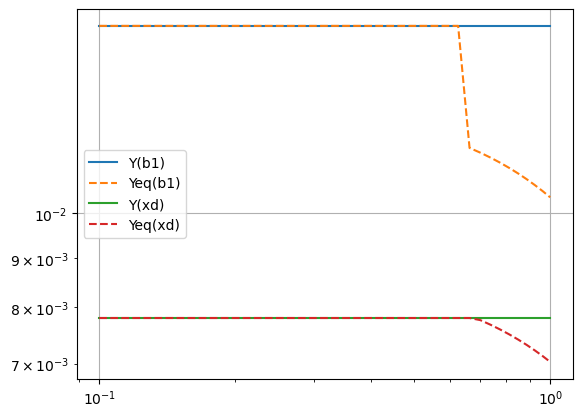

In [12]:
Tvals = mDM/xvals
for comp in compDict.values():
    if comp.ID == 0: continue
    # plt.plot(sol.t,sol.y[comp.ID,:],label=f'Y({comp.label})')
    Yeq = [comp.Yeq(t) for t in Tvals]
    plt.plot(xvals,Yf_sol[comp.ID,:],label=f'Y({comp.label})')
    plt.plot(xvals,Yeq,label=f'Yeq({comp.label})', linestyle='dashed')

plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-10,1e-1)
# plt.ylim(1e-4,10)
plt.grid()
# plt.title(r'$Y_{f} = $%1.3e (from dYdx), %1.3e (from dGdx)' %(Y_sol0[-1][0],Y_sol[-1][0]))
plt.show()

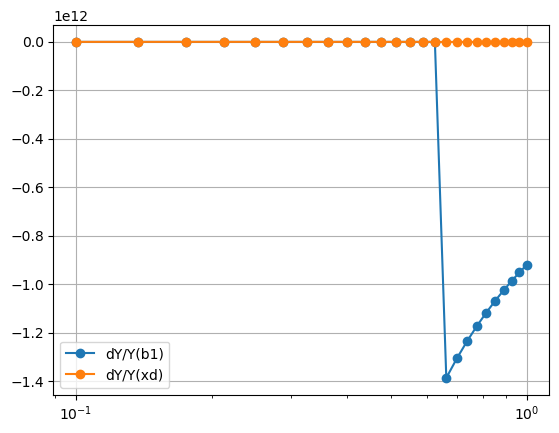

In [13]:
# sigmaV = np.array([sum([process.sigmaV(t) for process in model.collisionProcesses]) for t in Tvals])
# sigmaV = sigmaV/np.mean(sigmaV)
dY = np.array([dYdx(x,Yf_sol[:,i],model) for i,x in enumerate(xvals)]).transpose()
for comp in compDict.values():
    if comp.ID == 0: continue
    # plt.plot(sol.t,sol.y[comp.ID,:],label=f'Y({comp.label})')
    # plt.plot(xvals,Yf_sol[comp.ID,:],label=f'Y({comp.label})', marker='o')
    # Yeq = [comp.Yeq(t) for t in Tvals]        
    # plt.plot(xvals,dY[comp.ID,:],label=f'dY({comp.label})', marker='o')
    plt.plot(xvals,dY[comp.ID,:]/Yf_sol[comp.ID,:],label=f'dY/Y({comp.label})', marker='o')
    # plt.plot(sol.t,sigmaV,label=f'sigmaV', marker='o')
plt.vlines(x=0.7,ymin=-0.01,ymax=0.02,colors='gray')
plt.legend()
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0.1,0.2)
# plt.ylim(1e-10,1e-1)
# plt.ylim(1e-8,1e8)
plt.grid()
# plt.title(r'$Y_{f} = $%1.3e (from dYdx), %1.3e (from dGdx)' %(Y_sol0[-1][0],Y_sol[-1][0]))
plt.show()

In [14]:
i = 0
coll = computeCollisionTerms(xvals[i],Yf_sol[:,i],model)
dec = computeDecayTerms(xvals[i],Yf_sol[:,i],model)
for comp in compDict.values():
    print(f'{comp} coll(x={xvals[i]:1.1g}) = {sum(coll[comp.ID].values()):1.3e}, (Y-Yeq)/Yeq = {(Yf_sol[comp.ID,i] - comp.Yeq(mDM/xvals[i]))/comp.Yeq(mDM/xvals[i])}')
# print(dec)
print(Yf_sol[:,i])
print(dYdx(xvals[i],Yf_sol[:,i],model))

SM coll(x=0.1) = 0.000e+00, (Y-Yeq)/Yeq = 0.0
b1 coll(x=0.1) = 0.000e+00, (Y-Yeq)/Yeq = 0.0
xd coll(x=0.1) = 0.000e+00, (Y-Yeq)/Yeq = 0.0
[0.27765663 0.01560599 0.007803  ]
[0. 0. 0.]


In [15]:
i = 1
coll = computeCollisionTerms(xvals[i],Yf_sol[:,i],model)
dec = computeDecayTerms(xvals[i],Yf_sol[:,i],model)
for comp in compDict.values():
    print(f'{comp} coll(x={xvals[i]:1.1g}) = {sum(coll[comp.ID].values()):1.3e}, (Y-Yeq)/Yeq = {(Yf_sol[comp.ID,i] - comp.Yeq(mDM/xvals[i]))/comp.Yeq(mDM/xvals[i])}')
# print(dec)
print(Yf_sol[:,i])
print(dYdx(xvals[i],Yf_sol[:,i],model))

SM coll(x=0.1) = 0.000e+00, (Y-Yeq)/Yeq = 0.0
b1 coll(x=0.1) = 3.446e-19, (Y-Yeq)/Yeq = -3.728361381784935e-08
xd coll(x=0.1) = -2.954e-41, (Y-Yeq)/Yeq = 1.1115751645302526e-16
[0.27765663 0.01560599 0.007803  ]
[ 0.00000000e+00  5.97124311e+04 -5.11886714e-18]


In [16]:
i = 14
coll = computeCollisionTerms(xvals[i],Yf_sol[:,i],model)
dec = computeDecayTerms(xvals[i],Yf_sol[:,i],model)
for comp in compDict.values():
    print(f'{comp} coll(x={xvals[i]:1.1g}) = {sum(coll[comp.ID].values()):1.3e}, (Y-Yeq)/Yeq = {(Yf_sol[comp.ID,i] - comp.Yeq(mDM/xvals[i]))/comp.Yeq(mDM/xvals[i])}')
# print(dec)
print(Yf_sol[:,i])
print(dYdx(xvals[i],Yf_sol[:,i],model))

SM coll(x=0.6) = 0.000e+00, (Y-Yeq)/Yeq = 0.0
b1 coll(x=0.6) = -1.139e-19, (Y-Yeq)/Yeq = 8.818890432774174e-09
xd coll(x=0.6) = -4.419e-26, (Y-Yeq)/Yeq = 1.1115751645302526e-16
[0.27765663 0.01560599 0.007803  ]
[ 0.00000000e+00 -9.55100039e+02 -3.70558682e-04]


In [17]:
i = 15
coll = computeCollisionTerms(xvals[i],Yf_sol[:,i],model)
dec = computeDecayTerms(xvals[i],Yf_sol[:,i],model)
for comp in compDict.values():
    print(f'{comp} coll(x={xvals[i]:1.1g}) = {sum(coll[comp.ID].values()):1.3e}, (Y-Yeq)/Yeq = {(Yf_sol[comp.ID,i] - comp.Yeq(mDM/xvals[i]))/comp.Yeq(mDM/xvals[i])}')
# print(dec)
print(Yf_sol[:,i])
print(dYdx(xvals[i],Yf_sol[:,i],model))

SM coll(x=0.7) = 0.000e+00, (Y-Yeq)/Yeq = 0.0
b1 coll(x=0.7) = -2.901e-12, (Y-Yeq)/Yeq = 0.33585068739563345
xd coll(x=0.7) = -1.357e-18, (Y-Yeq)/Yeq = 0.0
[0.27765663 0.01560599 0.007803  ]
[ 0.00000000e+00 -2.16502371e+10 -1.01258276e+04]


In [18]:
i = 16
coll = computeCollisionTerms(xvals[i],Yf_sol[:,i],model)
dec = computeDecayTerms(xvals[i],Yf_sol[:,i],model)
for comp in compDict.values():
    print(f'{comp} coll(x={xvals[i]:1.1g}) = {sum(coll[comp.ID].values()):1.3e}, (Y-Yeq)/Yeq = {(Yf_sol[comp.ID,i] - comp.Yeq(mDM/xvals[i]))/comp.Yeq(mDM/xvals[i])}')
# print(dec)
print(Yf_sol[:,i])
print(dYdx(xvals[i],Yf_sol[:,i],model))

SM coll(x=0.7) = 0.000e+00, (Y-Yeq)/Yeq = 0.0
b1 coll(x=0.7) = -3.047e-12, (Y-Yeq)/Yeq = 0.3510176952409676
xd coll(x=0.7) = -1.524e-18, (Y-Yeq)/Yeq = 0.0050353476656235805
[0.27765663 0.01560599 0.007803  ]
[ 0.00000000e+00 -2.03713913e+10 -1.01865399e+04]


In [19]:
Yf_sol

array([[0.27765663, 0.27765663, 0.27765663, 0.27765663, 0.27765663,
        0.27765663, 0.27765663, 0.27765663, 0.27765663, 0.27765663,
        0.27765663, 0.27765663, 0.27765663, 0.27765663, 0.27765663,
        0.27765663, 0.27765663, 0.27765663, 0.27765663, 0.27765663,
        0.27765663, 0.27765663, 0.27765663, 0.27765663, 0.27765663],
       [0.01560599, 0.01560599, 0.01560599, 0.01560599, 0.01560599,
        0.01560599, 0.01560599, 0.01560599, 0.01560599, 0.01560599,
        0.01560599, 0.01560599, 0.01560599, 0.01560599, 0.01560599,
        0.01560599, 0.01560599, 0.01560599, 0.015606  , 0.015606  ,
        0.01560599, 0.01560599, 0.01560599, 0.01560599, 0.01560599],
       [0.007803  , 0.007803  , 0.007803  , 0.007803  , 0.007803  ,
        0.007803  , 0.007803  , 0.007803  , 0.007803  , 0.007803  ,
        0.007803  , 0.007803  , 0.007803  , 0.007803  , 0.007803  ,
        0.007803  , 0.007803  , 0.007803  , 0.007803  , 0.007803  ,
        0.007803  , 0.007803  , 0.007803  , 0.